<a href="https://colab.research.google.com/github/yoshimethod/bioinformatics/blob/main/bioinformatics_pr4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics==0.7.1
!pip install biopython

In [2]:
import os
import urllib.request
import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional
import torch.optim
from sklearn.metrics import accuracy_score
from torchmetrics.functional import precision_recall
import matplotlib
import matplotlib.pyplot as plt
import Bio
from Bio.Seq import Seq

In [3]:
normal_rna =Seq('GCATGCTGCATGCATGATGCCATGCATGCTGCATGCTGCATG')
tumor_rna  =Seq('GCATGCTGCATGCATGATGCCACGCATGCTGCATGCTGCATG')

print('野生型RNA配列:..' + str(normal_rna) + "..")
print('腫瘍特異的RNA配列:..' + str(tumor_rna) + "..")

print('野生型タンパク質配列:..' + str(normal_rna.translate()) +"..")
print('腫瘍特異的タンパク質配列:..' + str(tumor_rna.translate()) + "..")

野生型RNA配列:..GCATGCTGCATGCATGATGCCATGCATGCTGCATGCTGCATG..
腫瘍特異的RNA配列:..GCATGCTGCATGCATGATGCCACGCATGCTGCATGCTGCATG..
野生型タンパク質配列:..ACCMHDAMHAACCM..
腫瘍特異的タンパク質配列:..ACCMHDATHAACCM..


In [4]:
'''
1. まずはデータをダウンロードする
'''

data_dir = './pepdata/'
if not os.path.exists(data_dir):
  os.mkdir(data_dir)

train_url = 'https://github.com/haoqing12/APPM/raw/master/DATA/train_data/A0301'
test_url  = 'https://github.com/haoqing12/APPM/raw/master/DATA/test_data/A0301'

train_save_path = os.path.join(data_dir, 'train_A0301.csv')
test_save_path  = os.path.join(data_dir, 'test_A0301.csv')

urllib.request.urlretrieve(train_url, train_save_path)
urllib.request.urlretrieve(test_url, test_save_path)

print('Stored training-data name is', train_save_path)
print('Stored test-data name is', test_save_path)

pd.read_csv(train_save_path, nrows=5).head

Stored training-data name is ./pepdata/train_A0301.csv
Stored test-data name is ./pepdata/test_A0301.csv


<bound method NDFrame.head of       Peptide      HLA  BindingCategory
0   GTFGGLGSK  A*03:01                1
1   TTQDPLSNK  A*03:01                1
2  TVAGGAWTYK  A*03:01                1
3  FVYDHVFAEK  A*03:01                1
4   KVTEWQQTY  A*03:01                1>

In [5]:
'''
2. トランスフォーマーオブジェクトの作成
'''

class PepTransform():
  allSequences = 'ACEDGFIHKMLNQPSRTWVYZ' #アミノ酸配列
  char2int = dict((c, i) for i, c in enumerate(allSequences))

  def peptideOneHotMap(self, peptide):
    peptide_integar = [self.char2int[char] for char in peptide]
    peptide_onehot = list()
    for value in peptide_integar:
      letter = [0 for _ in range(len(self.allSequences))]
      letter[value] = 1
      peptide_onehot.append(letter)
    return np.asarray(peptide_onehot)

  def __init__(self):
    '''インスタンス変数の初期化
    '''

  def __call__(self, peptide):
    '''コールバック関数
    '''
    return self.peptideOneHotMap(peptide)

In [6]:
'''
3. ペプチドの長さを一定に変更する関数を作成
'''

def complementPeptides(peptides_series):
  peptides_list=peptides_series.tolist()

  for i in range(len(peptides_list)):
    if len(peptides_list[i]) < 11:
      peptides_list[i] = peptides_list[i] +'Z' * (11-len(peptides_list[i])) #11未満であれば後ろにZを足す
    else:
      peptides_list[i] = peptides_list[i][:11] #11以上であれば11番目までを残す
  return peptides_list

peptides_list = ['ACCMHDACCMHDAAA', 'ACCMHDATH']

for i in range(len(peptides_list)):
  if len(peptides_list[i]) < 11:
    peptides_list[i] = peptides_list[i] +'Z' *(11-len(peptides_list[i]))
  else:
    peptides_list[i] =peptides_list[i][:11]
  print("Generated Peptide is: " + peptides_list[i])

Generated Peptide is: ACCMHDACCMH
Generated Peptide is: ACCMHDATHZZ


In [7]:
'''
4. 学習に用いるペプチドのデータセットを作成するクラス
'''
class MakeDataset(data.Dataset):
  def __init__(self, save_path, transform=None):
    super().__init__()
    df = pd.read_csv(save_path, header=0)
    df = df[df['Peptide'].str.contains('X')==False]
    df = df[df['Peptide'].str.contains('B')==False]
    df = df[df['Peptide'].str.contains('U')==False]
    print(df)

    print('{0}のファイル'.format(save_path))
    print('#Original Negative data is: ' + str(df.loc[df['BindingCategory']==0].shape))
    print('#Original Positive data is: ' + str(df.loc[df['BindingCategory']==1].shape)
    + '\n')

    if 'train' in save_path:
      df_0 = df.loc[df['BindingCategory']==0]
      df_1 = df.loc[df['BindingCategory']==1]
      df = pd.concat([df_0, df_1, df_1], axis=0)
      print('オーバーサンプリング後:')
      print('#Original Negative data is: ' + str(df.loc[df['BindingCategory']==0].shape))
      print('#Original Positive data is: ' + str(df.loc[df['BindingCategory']==1].shape)
    + '\n')

    df=df.sample(frac=1).reset_index()
    self.peptides=complementPeptides(df['Peptide'])
    self.y=df['BindingCategory']
    self.transform=transform

  def __len__(self):
    return len(self.peptides)

  def __getitem__(self, index):
    peptide_transformed=self.transform(self.peptides[index])
    X = torch.from_numpy(peptide_transformed.astype(np.float32)).clone()
    Y = torch.tensor(self.y[index], dtype=torch.long).clone()
    return torch.reshape(X, (1, X.shape[0], X.shape[1])), Y


In [8]:
'''
5. データローダーの生成
'''
batch_size = 32

train_dataset = MakeDataset(
    save_path = train_save_path,
    transform = PepTransform()
)

test_dataset  = MakeDataset(
    save_path = test_save_path,
    transform = PepTransform()
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for (x,t) in train_dataloader:
  print(x.shape)
  print(t.shape)
  break

for (x,t) in test_dataloader:
  print(x.shape)
  print(t.shape)
  break


           Peptide      HLA  BindingCategory
0        GTFGGLGSK  A*03:01                1
1        TTQDPLSNK  A*03:01                1
2       TVAGGAWTYK  A*03:01                1
3       FVYDHVFAEK  A*03:01                1
4        KVTEWQQTY  A*03:01                1
...            ...      ...              ...
77531    TMPSTACHP  A*03:01                0
77532    NFVEQNMKI  A*03:01                0
77533   IGLRLAQEKA  A*03:01                0
77534   GEDGAGAGAE  A*03:01                0
77535  ILKHPSLARRI  A*03:01                0

[77531 rows x 3 columns]
./pepdata/train_A0301.csvのファイル
#Original Negative data is: (73112, 3)
#Original Positive data is: (4419, 3)

オーバーサンプリング後:
#Original Negative data is: (73112, 3)
#Original Positive data is: (8838, 3)

           Peptide      HLA  BindingCategory
0      KLLDEAIQAVK  A*03:01                1
1        GTYVSSVPR  A*03:01                1
2      VLFDTQLIIEK  A*03:01                1
3        ASFQSTSVK  A*03:01                1
4        

In [12]:
'''
6. 畳み込みニューラルネットワークの構築
'''

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    #第１層：畳み込み層1
    self.conv1a = nn.Conv2d(in_channels=1,
                            out_channels=128,
                            kernel_size=(2,2),
                            stride=(1,1),
                            padding=1,
                            padding_mode='zeros')
    self.dropout1a = nn.Dropout(0.40)

    #第２層：畳み込み層2
    self.conv1b = nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(2,2),
                          stride=(2,2),
                          padding=1,
                          padding_mode='zeros')
    self.dropout1b = nn.Dropout(0.40)

    #第３層：畳み込み層3
    self.conv1c = nn.Conv2d(in_channels=128,
                            out_channels=256,
                            kernel_size=(2,2),
                            stride=(2,2),
                            padding=1,
                            padding_mode='zeros')
    self.dropout1c = nn.Dropout(0.40)

    #第４層：畳み込み層4
    self.conv1d = nn.Conv2d(in_channels=256,
                            out_channels=256,
                            kernel_size=(2,2),
                            stride=(1,1),
                            padding=1,
                            padding_mode='zeros')
    self.dropout1d =nn.Dropout(0.40)

    #第５層：畳み込み層5
    self.conv1e = nn.Conv2d(in_channels=256,
                            out_channels=256,
                            kernel_size=(2,2),
                            stride=(1,1),
                            padding=1,
                            padding_mode='zeros')
    self.dropout1e =nn.Dropout(0.40)

    #第６層：畳み込み層6
    self.conv1f = nn.Conv2d(in_channels=256,
                            out_channels=512,
                            kernel_size=(1,2),
                            stride=(1,2),
                            padding=0,
                            padding_mode='zeros')
    self.dropout1f = nn.Dropout(0.40)

    #第７層：畳み込み層7
    self.conv1g = nn.Conv2d(in_channels=512,
                            out_channels=512,
                            kernel_size=(1,1),
                            stride=(1,1),
                            padding=0,
                            padding_mode='zeros')
    self.dropout1g = nn.Dropout(0.40)

    #第８層：畳み込み層8
    self.conv1h = nn.Conv2d(in_channels=512,
                            out_channels=256,
                            kernel_size=(1,1),
                            stride=(1,1),
                            padding=0,
                            padding_mode='zeros')
    self.dropout1 =nn.Dropout(0.50)

    #第９層：全結合層
    self.fc1 = nn.Linear(256*6*4, 128)
    self.dropout2 =nn.Dropout(0.25)

    #第１０層：出力層
    self.fc2 = nn.Linear(128, 2)

  def forward(self, x):
    x = torch.relu(self.conv1a(x))
    x = self.dropout1a(x)
    x = torch.relu(self.conv1b(x))
    x = self.dropout1b(x)
    x = torch.relu(self.conv1c(x))
    x = self.dropout1c(x)
    x = torch.relu(self.conv1d(x))
    x = self.dropout1d(x)
    x = torch.relu(self.conv1e(x))
    x = self.dropout1e(x)
    x = torch.relu(self.conv1f(x))
    x = self.dropout1f(x)
    x = torch.relu(self.conv1g(x))
    x = self.dropout1g(x)
    x = torch.relu(self.conv1h(x))

    x = self.dropout1(x)
    x = x.view(-1, 256*6*4)
    x = torch.relu(self.fc1(x))
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [13]:
'''
7. モデルのインスタンスを作成
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = CNN().to(device)
model

cuda


CNN(
  (conv1a): Conv2d(1, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (dropout1a): Dropout(p=0.4, inplace=False)
  (conv1b): Conv2d(128, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (dropout1b): Dropout(p=0.4, inplace=False)
  (conv1c): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (dropout1c): Dropout(p=0.4, inplace=False)
  (conv1d): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (dropout1d): Dropout(p=0.4, inplace=False)
  (conv1e): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (dropout1e): Dropout(p=0.4, inplace=False)
  (conv1f): Conv2d(256, 512, kernel_size=(1, 2), stride=(1, 2))
  (dropout1f): Dropout(p=0.4, inplace=False)
  (conv1g): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
  (dropout1g): Dropout(p=0.4, inplace=False)
  (conv1h): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6144, out_features

In [14]:
'''
8. 損失関数とオプティマイザの生成
'''
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
'''
9. パラメータの更新処理
'''
def train_step(x, target):
  model.train()
  preds=model(x)
  pr = precision_recall(preds, target, average='macro', num_classes=2)
  loss =criterion(preds, target)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss, preds, pr[0], pr[1]

In [16]:
'''
10. 評価用データセットを用いてモデルの評価を行う関数
'''
def test_step(x, target):
  model.eval()
  preds = model(x)
  pr = precision_recall(preds, target, average='macro', num_classes=2)
  loss = criterion(preds, t)
  return loss, preds, pr[0], pr[1]

In [ ]:
'''
11. モデルを使用して学習する
'''
epochs = 120
history = {'loss':[], 'accuracy':[], 'precision':[], 'recall':[], 'test_loss':[], 'test_accuracy':[], 'test_precision':[], 'test_recall':[]}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer,
    mode = 'max',
    factor = 0.1,
    patience = 5,
    min_lr =0.0001,
    verbose =True
)

for epoch in range(epochs):
  train_loss, train_acc, train_prec, train_recall = 0., 0., 0., 0.
  test_loss, test_acc, test_prec, test_recall = 0., 0., 0., 0.

  for (x, t) in train_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds, prec, recall =train_step(x, t)

    train_loss += loss.item()
    train_prec += prec.item()
    train_recall += recall.item()
    train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

  for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds, prec, recall =test_step(x, t)

    test_loss += loss.item()
    test_prec += prec.item()
    test_recall += recall.item()
    test_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

  avg_train_loss, avg_train_acc, = train_loss / len(train_dataloader), train_acc / len(train_dataloader)
  avg_train_prec, avg_train_recall = train_prec / len(train_dataloader), train_recall / len(train_dataloader)

  avg_test_loss, avg_test_acc, =test_loss / len(test_dataloader), test_acc / len(test_dataloader)
  avg_test_prec, avg_test_recall = test_prec / len(test_dataloader), test_recall / len(test_dataloader)

  history['loss'].append(avg_train_loss)
  history['accuracy'].append(avg_train_acc)
  history['precision'].append(avg_train_prec)
  history['recall'].append(avg_train_recall)

  history['test_loss'].append(avg_test_loss)
  history['test_accuracy'].append(avg_test_acc)
  history['test_precision'].append(avg_test_prec)
  history['test_recall'].append(avg_test_recall)

  print('epoch({0}) train loss: {1:.4} train_acc: {2:.4} train_precision: {3:.4} train_recall: {4:.4}'.format(epoch+1, avg_train_loss, avg_train_acc, avg_train_prec, avg_train_recall))
  print('epoch({0}) test_loss: {1:.4} test_acc: {2:.4} test_precision: {3:.4} test_recall: {4:.4}'.format(epoch+1, avg_test_loss, avg_test_acc, avg_test_prec, avg_test_recall))


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


epoch(1) train loss: 0.342 train_acc: 0.8922 train_precision: 0.456 train_recall: 0.5098
epoch(1) test_loss: 0.3062 test_acc: 0.9091 test_precision: 0.4778 test_recall: 0.5233
epoch(2) train loss: 0.342 train_acc: 0.8922 train_precision: 0.4558 train_recall: 0.5098
epoch(2) test_loss: 0.3062 test_acc: 0.9091 test_precision: 0.4778 test_recall: 0.5233
epoch(3) train loss: 0.342 train_acc: 0.8922 train_precision: 0.4558 train_recall: 0.5098
epoch(3) test_loss: 0.3062 test_acc: 0.9091 test_precision: 0.4778 test_recall: 0.5233
epoch(4) train loss: 0.342 train_acc: 0.8922 train_precision: 0.4558 train_recall: 0.5098
epoch(4) test_loss: 0.3062 test_acc: 0.9091 test_precision: 0.4778 test_recall: 0.5233
epoch(5) train loss: 0.342 train_acc: 0.8922 train_precision: 0.4558 train_recall: 0.5098
epoch(5) test_loss: 0.3062 test_acc: 0.9091 test_precision: 0.4778 test_recall: 0.5233
epoch(6) train loss: 0.3442 train_acc: 0.8922 train_precision: 0.4558 train_recall: 0.5098
epoch(6) test_loss: 0.306

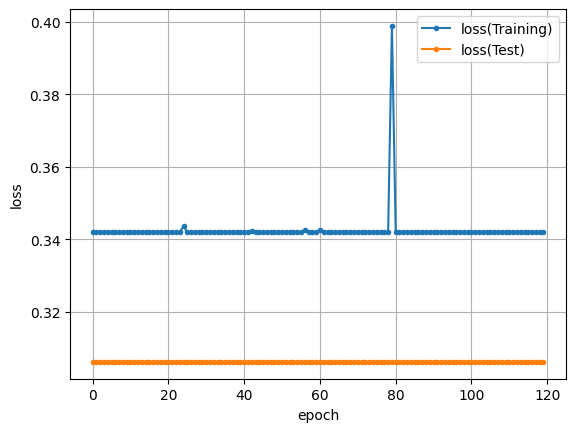

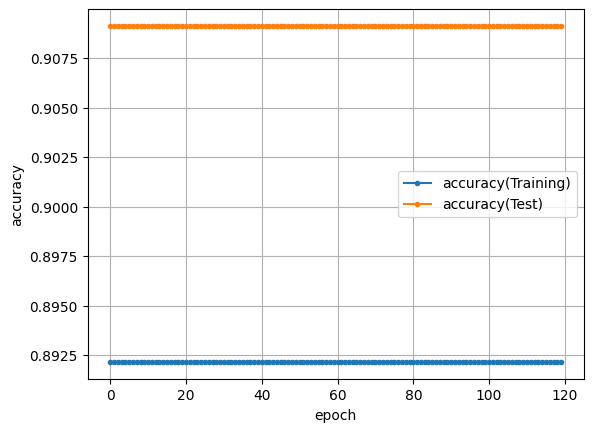

In [23]:
'''
12. 損失と精度をグラフにする
'''
plt.plot(history['loss'], marker='.', label='loss(Training)')
plt.plot(history['test_loss'], marker='.', label='loss(Test)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(history['accuracy'], marker='.', label='accuracy(Training)')
plt.plot(history['test_accuracy'], marker='.', label='accuracy(Test)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()